## Mnist Dataset Classification using K-Nearest Neighbors (Euclidean)

### Summary
<img align="right" src="../image/NearestNeighbor.png" width=150 height=150>
KNN은 새로운 데이터가 주어졌을 때 기존 데이터 가운데 가장 가까운 k개 이웃의 정보로 새로운 데이터를 예측하는 알고리즘

새로운 데이터가 주어진 경우 기존 모든 데이터와의 거리를 계산한다. 계산된 거리 값이 작은 k개의 데이터를 선정한다. 새로운 데이터의 클래스는 선정된 데이터들의 클래스 중 가장 많이 선택된 클래스로 분류한다.

거리 계산 방법에는 Euclidean, Mahalanobis 등 있다.

Mnist 데이터셋을 이용하여 0부터 9까지의 10가지 손글씨 클래스를 구분한다. 거리 계산 방법은 Euclidean을 사용한다.

Time 측정 방법은 Method 측면에서는 
1. Model Fitting Time : KNN의 경우 데이터셋에 대한 Checking 및 데이터셋 메모리에 카피
2. All Test Data Prediction Time
3. One Instance Prediction Time 10번 평균

PCA 측면에서는 
1. Calculate Train Data SVD Matrix Time
2. Transform Train X to N-PCA Time
3. Transform Test X to N-PCA Time

In [121]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader


In [4]:
class BaseConfig:
    def __init__(self):
        pass

    def info(self):
        config_list = {
            0 : ['Dataset', self.dataset, 
                 "Train size: " + str(int((1-self.test_size)*100))+"%",
                 'Feature size: ' + str(self.feature_size), 1],
            1 : ['Method', self.method, 
                 "k = " + str(self.k), self.distance, 2],
            2 : ['Dimension reduction', 
                 'Method: ' + str(self.reduction_method[0]),
                 'Component size: ' + str(self.reduction_method[1]),
                 'Feature Reduction Ratio: ' + \
                    str(round(self.reduction_method[1]/self.feature_size, 3)*100 if self.reduction_method[1] is not None else None)+"%", 3],
            3 : ['Iteration', str(self.iter), -1]
        }

        print("Device " + "─" * 2 + " " + self.device)
        print("│")

        parent = 1
        for child in range(len(config_list)):
            for idx, contents in enumerate(config_list[child][:-1]):
                if idx == 0 and child == len(config_list)-1:
                    print("└" + "─" * 2 + contents)
                elif idx == 0:
                    print("├" + "─" * 2 + contents)
                elif child == len(config_list)-1:
                    print(" " * 4 + "└" + "─" * 4 + contents)
                else:
                    print("│" + " " * 4 + "└" + "─" * 4 + contents)
            parent = config_list[child][-1]
            if parent == -1: break
            print("│")

    def print_rutin(self):
        if self.reduction_method[0] is None:
            rutin = str(self.device) + " - " + str(self.dataset) + "(" + str(int((1-self.test_size)*100)) + "%) - " + str(self.method) + " - " + str(self.iter) + " iteration"
            print(rutin)
        else:
            rutin = str(self.device) + " - " + str(self.dataset) + "(" + str(int((1-self.test_size)*100)) + "%) - " + str(self.method) + " - " + str(self.iter) + " iteration - " + str(self.reduction_method[0]) + "(feature " + str(self.reduction_method[1]) + ")"
            print(rutin)

class Config(BaseConfig):
    def __init__(self):
        super(BaseConfig, self).__init__()
        self.device = 'PC'
        self.dataset = 'Mnist'
        self.test_size = 0.2
        self.feature_size = 784
        self.method = 'kNN'
        self.k = 1
        self.distance = 'Euclidean'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10


## Load Mnist Dataset

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

In [30]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])

batch_size = 512

trainset = MNIST(root='../../../datasets', train=True, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validationset = MNIST(root='../../../datasets', train=False, download=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2)

print(trainset.data.shape)
print(validationset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
train_mnist = MNIST(root='../../../datasets', train=True, download=False)
test_mnist = MNIST(root='../../../datasets', train=False, download=False)

In [7]:
train_mnist_X, train_mnist_y = train_mnist.data.numpy(), train_mnist.targets.numpy()
test_mnist_X, test_mnist_y = test_mnist.data.numpy(), test_mnist.targets.numpy()

print(f'Train data X shape : {train_mnist_X.shape}, y shape : {train_mnist_y.shape}')
print(f'Test data X shape : {test_mnist_X.shape}, y shape : {test_mnist_y.shape}')

Train data X shape : (60000, 28, 28), y shape : (60000,)
Test data X shape : (10000, 28, 28), y shape : (10000,)


In [10]:
print(f'Mnist Data range [{train_mnist_X.min()}, {train_mnist_X.max()}] ')

train_mnist_X, test_mnist_X = train_mnist_X / 255., test_mnist_X / 255.

print(f'--> Mnist Data Normalized range [{train_mnist_X.min()}, {train_mnist_X.max()}] ')

Mnist Data range [0, 255] 
--> Mnist Data Normalized range [0.0, 1.0] 


## Sample Images

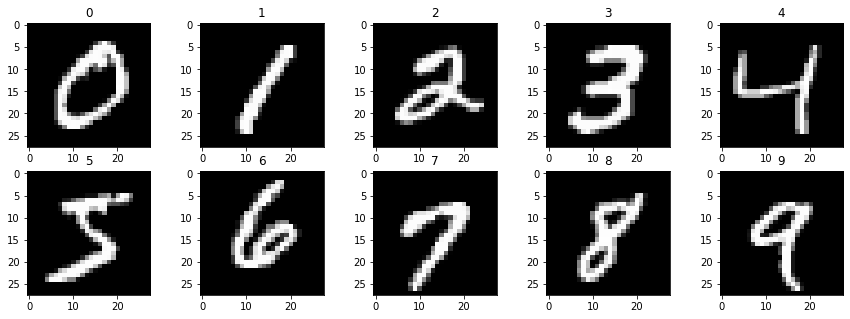

In [9]:
plt.figure(figsize=(15, 5))

for i in range(10):
    sample_idx = np.where(train_mnist_y == i)[0][0]

    sample_image = train_mnist_X[sample_idx]
    sample_label = train_mnist_y[sample_idx]

    plt.subplot(2, 5, i+1) # nrows, ncolumns, index
    plt.title(sample_label)
    plt.imshow(sample_image,'gray')
plt.show()

## Train & Test Data Label Distribution

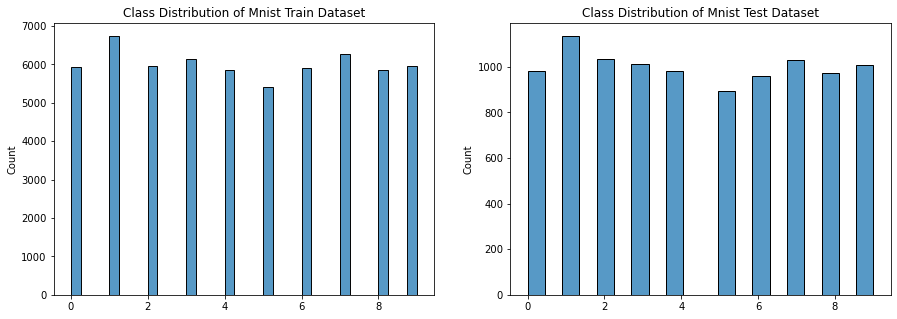

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_mnist_y, palette="tab10")
plt.title("Class Distribution of Mnist Train Dataset")

plt.subplot(1, 2, 2)
sns.histplot(test_mnist_y, palette="tab10")
plt.title("Class Distribution of Mnist Test Dataset")
plt.show()

## Preprocessing
 * Flatten 28 x 28 images to 784 vectors

In [11]:
print(f'Mnist Data shape train : {train_mnist_X.shape}, test : {test_mnist_X.shape}')

train_mnist_X = train_mnist_X.reshape(-1, 784)
test_mnist_X = test_mnist_X.reshape(-1, 784)

print(f'--> Mnist Data shape train : {train_mnist_X.shape}, test : {test_mnist_X.shape}')

Mnist Data shape train : (60000, 28, 28), test : (10000, 28, 28)
--> Mnist Data shape train : (60000, 784), test : (10000, 784)


In [13]:
scaler = preprocessing.StandardScaler()
normal = preprocessing.Normalizer()

scaler.fit(train_mnist_X)
normal.fit(train_mnist_X)

Normalizer()

In [15]:
x_s = scaler.transform(train_mnist_X)
x_n = normal.transform(train_mnist_X)

In [28]:
x_n.mean()

0.013792965378637572

## K-Nearest Neighbor

In [39]:
config = Config()
config.info()

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


### KNN run function

In [43]:
def knn_run(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            test_data_y = test_mnist_y,
            config = None,
            weights = 'distance'):

    assert config is not None
    # config.info()
    config.print_rutin()
    k = config.k
    max_seed = config.iter

    avg_test_acc = []
    avg_knn_fit_time = []
    avg_pred_time = []
    preds = []

    for seed in tqdm(range(max_seed)):
        x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

        knn = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=-1)

        start_time = time.perf_counter()
        knn.fit(x_train, y_train)
        knn_fit_time = time.perf_counter() - start_time
        avg_knn_fit_time.append(knn_fit_time)

        start_time = time.perf_counter()
        pred = knn.predict(x_test)
        pred_time = time.perf_counter() - start_time
        preds.append(pred)

        test_score = accuracy_score(pred, y_test)
        avg_test_acc.append(test_score)
        avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", len(x_test))
    print("-----" * 8)
    print("Test set score: %.4f ± %.5f" % (np.array(avg_test_acc).mean(), np.array(avg_test_acc).std()))
    print("KNN fitting Time: %.4f ± %.5f" % (np.array(avg_knn_fit_time).mean(), np.array(avg_knn_fit_time).std()), "sec")
    print("All Test dataset Prediction Time at once : %.4f ± %.5f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
    print("Divide the Prediction Time by Test size : %.8f ± %.8f" % (np.array(avg_pred_time).mean()/len(x_test), np.array(avg_pred_time).std()/len(x_test)), "sec")

    return avg_test_acc, avg_knn_fit_time, avg_pred_time

* K : {1, 2, 3, 5}-NN Results

In [44]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration


100%|██████████| 10/10 [01:23<00:00,  8.35s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9691 ± 0.00000
KNN fitting Time: 0.0028 ± 0.00031 sec
All Test dataset Prediction Time at once : 8.3492 ± 0.04587 sec
Divide the Prediction Time by Test size : 0.00083492 ± 0.00000459 sec


In [45]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration


100%|██████████| 10/10 [01:27<00:00,  8.75s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9691 ± 0.00000
KNN fitting Time: 0.0027 ± 0.00036 sec
All Test dataset Prediction Time at once : 8.7486 ± 0.06288 sec
Divide the Prediction Time by Test size : 0.00087486 ± 0.00000629 sec


In [46]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration


100%|██████████| 10/10 [01:31<00:00,  9.16s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9717 ± 0.00000
KNN fitting Time: 0.0026 ± 0.00011 sec
All Test dataset Prediction Time at once : 9.1586 ± 0.01919 sec
Divide the Prediction Time by Test size : 0.00091586 ± 0.00000192 sec


In [47]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration


100%|██████████| 10/10 [01:59<00:00, 11.90s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9691 ± 0.00000
KNN fitting Time: 0.0026 ± 0.00021 sec
All Test dataset Prediction Time at once : 11.8980 ± 0.06315 sec
Divide the Prediction Time by Test size : 0.00118980 ± 0.00000632 sec


### 1개의 Instance를 예측하는데 걸리는 시간 측정 - 10번 반복

In [66]:
def knn_run_one_instance(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            test_data_y = test_mnist_y,
            config = None,
            weights = 'distance'):

    assert config is not None
    config.info()
    k = config.k
    max_seed = config.iter


    x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)

    start_time = time.perf_counter()
    knn.fit(x_train, y_train)
    knn_fit_time = time.perf_counter() - start_time


    avg_pred_time = []
    preds = []
    ys_test = []
    count = 0

    for x_one, y_one in tqdm(zip(x_test, y_test)):
        x_one = x_one.reshape(1, -1)

        start = time.perf_counter()
        pred = knn.predict(x_one)
        pred_time = time.perf_counter() - start
        

        avg_pred_time.append(pred_time)
        preds.append(pred)
        ys_test.append(y_one)

        count += 1
        if count == 10:
            break

    test_score = accuracy_score(preds, ys_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", 10)
    print("-----" * 8)
    print("Test set score: %f" % np.array(avg_test_acc).mean())
    print("KNN fitting Time: %.4f" % (knn_fit_time), "sec")
    print("One Instance Prediction Average Time : %.8f ± %.8f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")

    return avg_test_acc, knn_fit_time, avg_pred_time

In [67]:
config.k = 1

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


9it [00:00, 12.99it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.985696
KNN fitting Time: 0.0031 sec
One Instance Prediction Average Time : 0.06916218 ± 0.00167305 sec


In [68]:
config.k = 2

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 2
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


9it [00:00, 10.81it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.986292
KNN fitting Time: 0.0031 sec
One Instance Prediction Average Time : 0.08337473 ± 0.00842552 sec


In [69]:
config.k = 3

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 3
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


9it [00:00, 12.06it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.986840
KNN fitting Time: 0.0031 sec
One Instance Prediction Average Time : 0.07372734 ± 0.00757569 sec


In [70]:
n_components_list = []
pca_fit_time_list = []
train_features_extract_time_list = []
test_features_extract_time_list = []

## PCA run function

In [71]:
def pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=None):

    assert config is not None
    config.info()

    n_components = config.reduction_method[1]

    pca_dims = PCA(n_components)
    print(f"The number of components : {n_components}")

    start_time = time.perf_counter()
    pca_dims.fit(train_data_X)
    pca_fit_time = time.perf_counter () - start_time
    print()
    print(f"Calculating SVD Matrix Time on Train Data-{train_data_X.shape} : {pca_fit_time:4f} sec")
    
    start_time = time.perf_counter()
    train_features = pca_dims.transform(train_data_X)
    train_features_extract_time = time.perf_counter () - start_time
    print(f"Transform train X-{train_data_X.shape} to {n_components}-PCA Time: {train_features_extract_time:4f} sec")

    start_time = time.perf_counter()
    test_features = pca_dims.transform(test_data_X)
    test_features_extract_time = time.perf_counter () - start_time
    print(f"Transform test X-{train_data_X.shape} to {n_components}-PCA Time: {test_features_extract_time:4f} sec")

    return pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time
    

### PCA feature 2

In [96]:
config.reduction_method = ['PCA', 2]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10
The number of components : 2

Calculating SVD Matrix Time on Train Data-(60000, 784) : 0.867288 sec
Transform train X-(60000, 784) to 2-PCA Time: 0.185606 sec
Transform test X-(60000, 784) to 2-PCA Time: 0.035618 sec


* 2 PCA features - 1-NN run

In [84]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 19.76it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.3898 ± 0.00000
KNN fitting Time: 0.0329 ± 0.00063 sec
All Test dataset Prediction Time at once : 0.0171 ± 0.00084 sec
Divide the Prediction Time by Test size : 0.00000171 ± 0.00000008 sec


* 2 PCA features - 2-NN run

In [85]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 18.83it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.3898 ± 0.00000
KNN fitting Time: 0.0333 ± 0.00098 sec
All Test dataset Prediction Time at once : 0.0190 ± 0.00033 sec
Divide the Prediction Time by Test size : 0.00000190 ± 0.00000003 sec


* 2 PCA features - 3-NN run

In [97]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 18.48it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4018 ± 0.00000
KNN fitting Time: 0.0332 ± 0.00069 sec
All Test dataset Prediction Time at once : 0.0201 ± 0.00045 sec
Divide the Prediction Time by Test size : 0.00000201 ± 0.00000005 sec


* 2 PCA features - 5-NN run

In [98]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 17.53it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4125 ± 0.00000
KNN fitting Time: 0.0338 ± 0.00222 sec
All Test dataset Prediction Time at once : 0.0225 ± 0.00136 sec
Divide the Prediction Time by Test size : 0.00000225 ± 0.00000014 sec


### PCA feature 3

In [99]:
config.reduction_method = ['PCA', 3]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10
The number of components : 3

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.079424 sec
Transform train X-(60000, 784) to 3-PCA Time: 0.187251 sec
Transform test X-(60000, 784) to 3-PCA Time: 0.036742 sec


* 3 PCA features - 1-NN run

In [87]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 14.99it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4428 ± 0.00000
KNN fitting Time: 0.0448 ± 0.00194 sec
All Test dataset Prediction Time at once : 0.0212 ± 0.00051 sec
Divide the Prediction Time by Test size : 0.00000212 ± 0.00000005 sec


* 3 PCA features - 2-NN run

In [88]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4428 ± 0.00000
KNN fitting Time: 0.0453 ± 0.00275 sec
All Test dataset Prediction Time at once : 0.0249 ± 0.00072 sec
Divide the Prediction Time by Test size : 0.00000249 ± 0.00000007 sec


* 3 PCA features - 3-NN run

In [89]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 13.72it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4600 ± 0.00000
KNN fitting Time: 0.0453 ± 0.00291 sec
All Test dataset Prediction Time at once : 0.0269 ± 0.00050 sec
Divide the Prediction Time by Test size : 0.00000269 ± 0.00000005 sec


* 3 PCA features - 5-NN run

In [100]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 13.09it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4757 ± 0.00000
KNN fitting Time: 0.0452 ± 0.00218 sec
All Test dataset Prediction Time at once : 0.0305 ± 0.00063 sec
Divide the Prediction Time by Test size : 0.00000305 ± 0.00000006 sec


### kNN with PCA feature 5

In [101]:
config.reduction_method = ['PCA', 5]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.6%
│
└──Iteration
    └────10
The number of components : 5

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.119668 sec
Transform train X-(60000, 784) to 5-PCA Time: 0.181248 sec
Transform test X-(60000, 784) to 5-PCA Time: 0.030710 sec


* 5 PCA features - 1-NN run

In [102]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  8.26it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.6937 ± 0.00000
KNN fitting Time: 0.0736 ± 0.00571 sec
All Test dataset Prediction Time at once : 0.0462 ± 0.00109 sec
Divide the Prediction Time by Test size : 0.00000462 ± 0.00000011 sec


* 5 PCA features - 2-NN run

In [103]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  7.75it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.6937 ± 0.00000
KNN fitting Time: 0.0714 ± 0.00518 sec
All Test dataset Prediction Time at once : 0.0565 ± 0.00072 sec
Divide the Prediction Time by Test size : 0.00000565 ± 0.00000007 sec


* 5 PCA features - 3-NN run

In [104]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  7.41it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.7263 ± 0.00000
KNN fitting Time: 0.0702 ± 0.00187 sec
All Test dataset Prediction Time at once : 0.0638 ± 0.00093 sec
Divide the Prediction Time by Test size : 0.00000638 ± 0.00000009 sec


* 5 PCA features - 5-NN run

In [105]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.7450 ± 0.00000
KNN fitting Time: 0.0702 ± 0.00328 sec
All Test dataset Prediction Time at once : 0.0733 ± 0.00108 sec
Divide the Prediction Time by Test size : 0.00000733 ± 0.00000011 sec


### kNN with PCA feature 26

In [106]:
config.reduction_method = ['PCA', 26]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 26
│    └────Feature Reduction Ratio: 3.3000000000000003%
│
└──Iteration
    └────10
The number of components : 26

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.096050 sec
Transform train X-(60000, 784) to 26-PCA Time: 0.252058 sec
Transform test X-(60000, 784) to 26-PCA Time: 0.047072 sec


* 26 PCA features - 1-NN run

In [107]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 26)


100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9717 ± 0.00000
KNN fitting Time: 0.0041 ± 0.00008 sec
All Test dataset Prediction Time at once : 5.6537 ± 0.06541 sec
Divide the Prediction Time by Test size : 0.00056537 ± 0.00000654 sec


* 26 PCA features - 2-NN run

In [108]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 26)


100%|██████████| 10/10 [01:00<00:00,  6.03s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9717 ± 0.00000
KNN fitting Time: 0.0060 ± 0.00132 sec
All Test dataset Prediction Time at once : 6.0233 ± 0.06874 sec
Divide the Prediction Time by Test size : 0.00060233 ± 0.00000687 sec


* 26 PCA features - 3-NN run

In [109]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 26)


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9743 ± 0.00000
KNN fitting Time: 0.0044 ± 0.00091 sec
All Test dataset Prediction Time at once : 6.4192 ± 0.06950 sec
Divide the Prediction Time by Test size : 0.00064192 ± 0.00000695 sec


* 26 PCA features - 5-NN run

In [110]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 26)


100%|██████████| 10/10 [01:28<00:00,  8.89s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9746 ± 0.00000
KNN fitting Time: 0.0044 ± 0.00108 sec
All Test dataset Prediction Time at once : 8.8802 ± 0.04971 sec
Divide the Prediction Time by Test size : 0.00088802 ± 0.00000497 sec


### kNN with PCA feature 43

In [111]:
config.reduction_method = ['PCA', 43]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 43
│    └────Feature Reduction Ratio: 5.5%
│
└──Iteration
    └────10
The number of components : 43

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.547433 sec
Transform train X-(60000, 784) to 43-PCA Time: 0.249204 sec
Transform test X-(60000, 784) to 43-PCA Time: 0.047305 sec


* 43 PCA features - 1-NN run

In [112]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 43)


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9735 ± 0.00000
KNN fitting Time: 0.0055 ± 0.00111 sec
All Test dataset Prediction Time at once : 5.6355 ± 0.09007 sec
Divide the Prediction Time by Test size : 0.00056355 ± 0.00000901 sec


* 43 PCA features - 2-NN run

In [113]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 43)


100%|██████████| 10/10 [01:00<00:00,  6.06s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9735 ± 0.00000
KNN fitting Time: 0.0061 ± 0.00153 sec
All Test dataset Prediction Time at once : 6.0498 ± 0.05053 sec
Divide the Prediction Time by Test size : 0.00060498 ± 0.00000505 sec


* 43 PCA features - 3-NN run

In [114]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 43)


100%|██████████| 10/10 [01:04<00:00,  6.45s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9763 ± 0.00000
KNN fitting Time: 0.0052 ± 0.00019 sec
All Test dataset Prediction Time at once : 6.4457 ± 0.06940 sec
Divide the Prediction Time by Test size : 0.00064457 ± 0.00000694 sec


* 43 PCA features - 5-NN run

In [115]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - PCA(feature 43)


100%|██████████| 10/10 [01:29<00:00,  8.99s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9753 ± 0.00000
KNN fitting Time: 0.0051 ± 0.00016 sec
All Test dataset Prediction Time at once : 8.9841 ± 0.03194 sec
Divide the Prediction Time by Test size : 0.00089841 ± 0.00000319 sec


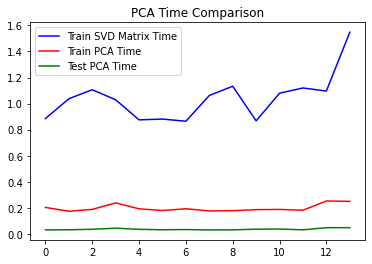

In [117]:
plt.figure()
plt.plot(pca_fit_time_list, "b", label="Train SVD Matrix Time")
plt.legend()
plt.plot(train_features_extract_time_list, "r", label="Train PCA Time")
plt.plot(test_features_extract_time_list, "g", label="Test PCA Time")
plt.legend()
plt.title("PCA Time Comparison")
plt.show()

In [122]:
n_components_list = []
lda_fit_time_list = []
train_features_extract_time_list = []
test_features_extract_time_list = []

## LDA run function

In [125]:
def lda_run(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            config=None):

    assert config is not None
    config.info()

    n_components = config.reduction_method[1]

    lda_dims = LinearDiscriminantAnalysis(n_components=n_components)
    print(f"The number of components : {n_components}")

    start_time = time.perf_counter()
    lda_dims.fit(train_data_X, train_data_y)
    lda_fit_time = time.perf_counter () - start_time
    print()
    print(f"Calculating LDA Matrix Time on Train Data-{train_data_X.shape} : {lda_fit_time:4f} sec")
    
    start_time = time.perf_counter()
    train_features = lda_dims.transform(train_data_X)
    train_features_extract_time = time.perf_counter () - start_time
    print(f"Transform train X-{train_data_X.shape} to {n_components}-LDA Time: {train_features_extract_time:4f} sec")

    start_time = time.perf_counter()
    test_features = lda_dims.transform(test_data_X)
    test_features_extract_time = time.perf_counter () - start_time
    print(f"Transform test X-{train_data_X.shape} to {n_components}-LDA Time: {test_features_extract_time:4f} sec")

    return lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time

### LDA feature 2

In [126]:
config.reduction_method = ['LDA', 2]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10
The number of components : 2

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.025529 sec
Transform train X-(60000, 784) to 2-LDA Time: 0.105201 sec
Transform test X-(60000, 784) to 2-LDA Time: 0.016841 sec


* 2 LDA features - 1-NN run

In [127]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 18.48it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4710 ± 0.00000
KNN fitting Time: 0.0354 ± 0.00273 sec
All Test dataset Prediction Time at once : 0.0179 ± 0.00056 sec
Divide the Prediction Time by Test size : 0.00000179 ± 0.00000006 sec


* 2 LDA features - 2-NN run

In [128]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 18.34it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4710 ± 0.00000
KNN fitting Time: 0.0343 ± 0.00162 sec
All Test dataset Prediction Time at once : 0.0196 ± 0.00055 sec
Divide the Prediction Time by Test size : 0.00000196 ± 0.00000005 sec


* 2 LDA features - 3-NN run

In [129]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 18.25it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4911 ± 0.00000
KNN fitting Time: 0.0336 ± 0.00083 sec
All Test dataset Prediction Time at once : 0.0206 ± 0.00040 sec
Divide the Prediction Time by Test size : 0.00000206 ± 0.00000004 sec


* 2 LDA features - 5-NN run

In [130]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 16.61it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.5115 ± 0.00000
KNN fitting Time: 0.0359 ± 0.00373 sec
All Test dataset Prediction Time at once : 0.0235 ± 0.00048 sec
Divide the Prediction Time by Test size : 0.00000235 ± 0.00000005 sec


### LDA feature 3

In [132]:
config.reduction_method = ['LDA', 3]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10
The number of components : 3

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.016360 sec
Transform train X-(60000, 784) to 3-LDA Time: 0.102001 sec
Transform test X-(60000, 784) to 3-LDA Time: 0.019093 sec


* 3 LDA features - 1-NN run

In [133]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 14.73it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.6689 ± 0.00000
KNN fitting Time: 0.0453 ± 0.00233 sec
All Test dataset Prediction Time at once : 0.0217 ± 0.00072 sec
Divide the Prediction Time by Test size : 0.00000217 ± 0.00000007 sec


* 3 LDA features - 2-NN run

In [134]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 14.16it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.6689 ± 0.00000
KNN fitting Time: 0.0445 ± 0.00053 sec
All Test dataset Prediction Time at once : 0.0254 ± 0.00078 sec
Divide the Prediction Time by Test size : 0.00000254 ± 0.00000008 sec


* 3 LDA features - 3-NN run

In [135]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 13.74it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.6989 ± 0.00000
KNN fitting Time: 0.0446 ± 0.00055 sec
All Test dataset Prediction Time at once : 0.0274 ± 0.00063 sec
Divide the Prediction Time by Test size : 0.00000274 ± 0.00000006 sec


* 3 LDA features - 5-NN run

In [136]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 13.17it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.7188 ± 0.00000
KNN fitting Time: 0.0446 ± 0.00044 sec
All Test dataset Prediction Time at once : 0.0306 ± 0.00053 sec
Divide the Prediction Time by Test size : 0.00000306 ± 0.00000005 sec


### LDA feature 5

In [137]:
config.reduction_method = ['LDA', 5]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.6%
│
└──Iteration
    └────10
The number of components : 5

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.020673 sec
Transform train X-(60000, 784) to 5-LDA Time: 0.094121 sec
Transform test X-(60000, 784) to 5-LDA Time: 0.015756 sec


* 5 LDA features - 1-NN run

In [138]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  8.52it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.7903 ± 0.00000
KNN fitting Time: 0.0698 ± 0.00383 sec
All Test dataset Prediction Time at once : 0.0465 ± 0.00091 sec
Divide the Prediction Time by Test size : 0.00000465 ± 0.00000009 sec


* 5 LDA features - 2-NN run

In [139]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.7903 ± 0.00000
KNN fitting Time: 0.0692 ± 0.00198 sec
All Test dataset Prediction Time at once : 0.0570 ± 0.00147 sec
Divide the Prediction Time by Test size : 0.00000570 ± 0.00000015 sec


* 5 LDA features - 3-NN run

In [140]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  7.30it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8205 ± 0.00000
KNN fitting Time: 0.0714 ± 0.00502 sec
All Test dataset Prediction Time at once : 0.0646 ± 0.00104 sec
Divide the Prediction Time by Test size : 0.00000646 ± 0.00000010 sec


* 5 LDA features - 5-NN run

In [141]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 5)


100%|██████████| 10/10 [00:01<00:00,  6.90it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8327 ± 0.00000
KNN fitting Time: 0.0688 ± 0.00265 sec
All Test dataset Prediction Time at once : 0.0750 ± 0.00090 sec
Divide the Prediction Time by Test size : 0.00000750 ± 0.00000009 sec


### LDA feature 9

In [143]:
config.reduction_method = ['LDA', 9]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 9
│    └────Feature Reduction Ratio: 1.0999999999999999%
│
└──Iteration
    └────10
The number of components : 9

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.046038 sec
Transform train X-(60000, 784) to 9-LDA Time: 0.134999 sec
Transform test X-(60000, 784) to 9-LDA Time: 0.027631 sec


* 9 LDA features - 1-NN run

In [144]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 9)


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8990 ± 0.00000
KNN fitting Time: 0.1145 ± 0.00345 sec
All Test dataset Prediction Time at once : 0.2148 ± 0.00140 sec
Divide the Prediction Time by Test size : 0.00002148 ± 0.00000014 sec


* 9 LDA features - 2-NN run

In [145]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 9)


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8990 ± 0.00000
KNN fitting Time: 0.1119 ± 0.00084 sec
All Test dataset Prediction Time at once : 0.2646 ± 0.00187 sec
Divide the Prediction Time by Test size : 0.00002646 ± 0.00000019 sec


* 9 LDA features - 3-NN run

In [146]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 9)


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9109 ± 0.00000
KNN fitting Time: 0.1121 ± 0.00276 sec
All Test dataset Prediction Time at once : 0.2962 ± 0.00623 sec
Divide the Prediction Time by Test size : 0.00002962 ± 0.00000062 sec


* 9 LDA features - 5-NN run

In [147]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

PC - Mnist(80%) - kNN - 10 iteration - LDA(feature 9)


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.9148 ± 0.00000
KNN fitting Time: 0.1117 ± 0.00125 sec
All Test dataset Prediction Time at once : 0.3383 ± 0.00647 sec
Divide the Prediction Time by Test size : 0.00003383 ± 0.00000065 sec
